# OpenJij 入門

OpenJijは イジング模型および,QUBOのヒューリステック最適化ライブラリです。  
最適化計算のコア部分はC++で実装されていますが、Pythonインターフェースを備えているため、Pythonから簡単に最適化を行うことができます。

In [1]:
!pip install openjij


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Check the installed version of OpenJij
!pip show openjij | grep "Version:"

Version: 0.9.2


## OpenJijによるイジング模型を用いた最適化計算

[組合せ最適化とイジング模型](./000-combinatorial_optimization_and_Ising_model.ipynb)で説明したように、
イジング模型は磁性体の振る舞いを理解するために提案された模型で、以下のように書かれます。

$$H(\{\sigma_i\}) = \sum_{i > j} J_{ij}\sigma_i \sigma_j + \sum_{i=1}^N h_i \sigma_i$$
$$\sigma_i \in \{-1, 1\}, i=1,\cdots N$$

ここで$H(\{\sigma_i\})$はハミルトニアンと呼ばれます。エネルギーやコスト関数だと考えてください。  
$\sigma_i$は$\{1, -1\}$の2値を取る変数です。  

> $\sigma_i$は物理ではスピンという物理量に対応するため、スピン変数もしくは単純にスピンと呼ばれることもあります。  
> スピンとは小さな磁石のようなものです。-1 が磁石が上向き、1が下向きのように変数の値と物理(磁石の向き)が対応します。


$H$は変数の組み合わせ$\{\sigma_i\} = \{\sigma_1, \sigma_2, \cdots, \sigma_N\}$に依存します。  
$J_{ij}, h_i$が与えられる問題を表しています。それぞれ相互作用係数、縦磁場と呼ばれます。

OpenJijは、インプットとして、$J_{ij}$と$h_i$が与えられたときに、Simulated AnnealingやSimulated Quantum Annealingを行う数値計算ライブラリであり、
OpenJijを用いることで、$H(\{\sigma_i\})$を最小化するスピン変数の組み$\{\sigma_i\}$を探すことができます。


### OpenJijに問題を投げてみる
まずは、簡単な例でどのようにOpenJijを用いるかをみていきます。
変数の数が$N=5$で縦磁場と相互作用が

$$h_i = -1~\text{for} ~\forall i, ~ J_{ij} = -1~\text{for} ~\forall i, j$$

の問題を考えてみましょう。全ての相互作用がマイナスなので、各スピン変数は同じ値をとった方がエネルギーは低くなることがわかります。
また縦磁場は全てマイナスなので、各スピンは1の値をとった方がエネルギーが低くなります。  
よってこの問題の最適解は $\{\sigma_i\} = \{1, 1, 1, 1, 1\}$になります。

では、実際にこの結果が得られるかOpenJijを用いて計算してみましょう。

まず初めに、インプットデータとして、$h_i$と$J_{ij}$を用意します。
ここでは、それぞれの添字をkeyとし、値をvalueとした辞書を作成します。

In [3]:
import openjij as oj

# 問題を表す縦磁場と相互作用を作ります。OpenJijでは辞書型で問題を受け付けます。
N = 5
h = {i: -1 for i in range(N)}
J = {(i, j): -1 for i in range(N) for j in range(i+1, N)}

print('h_i: ', h)
print('Jij: ', J)

h_i:  {0: -1, 1: -1, 2: -1, 3: -1, 4: -1}
Jij:  {(0, 1): -1, (0, 2): -1, (0, 3): -1, (0, 4): -1, (1, 2): -1, (1, 3): -1, (1, 4): -1, (2, 3): -1, (2, 4): -1, (3, 4): -1}


つづいて、実際に最適化計算を行なっていきます。
ここでは、焼きなまし法を行うために、`oj.SASampler`のインスタンスを作成します。
ここでは、`sample_ising`メソッドの引数に$h_i$と$J_{ij}$を渡してあげることで、焼きなまし法が実行されます。

`oj.SASampler`、`sample_ising`の詳細および、その返り値については、このノートの最後に説明します。

In [4]:
# まず問題を解いてくれるSamplerのインスタンスを作ります。
sampler = oj.SASampler()
# samplerのメソッドに問題(h, J)を投げて問題を解きます。
response = sampler.sample_ising(h, J, num_reads=1)

# 計算した結果(状態)は response.states に入っています。
print(response.states)

# もしくは添字付きでみるには samples関数 を用います。
print([s for s in response.samples()])

[[1 1 1 1 1]]
[{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}]


確かに、我々の予想通り全てのスピンが1となった状態が得られました。

先ほどは、$h_i$と$J_{ij}$を辞書として渡しましたが、巨大な問題を扱う際にはnumpyを用いた入力が便利となります。
OpenJijでは、以下の形のnumpyの行列を渡すことで、OpenJijが解くことができる形に変換する`oj.BinaryQuadraticModel.from_numpy_matrix`が用意されています。

$$ \begin{pmatrix}
h_{0} & J_{0,1} & \cdots & J_{0,N-1}\\
J_{1,0} & h_{1} & \cdots & J_{1,N-1}\\
\vdots & \vdots & \vdots & \vdots\\
J_{N-1,0} & J_{N-1,1} & \cdots & h_{N-1}\\
\end{pmatrix} $$

In [5]:
import numpy as np
mat = np.array([[-1,-0.5,-0.5,-0.5],[-0.5,-1,-0.5,-0.5],[-0.5,-0.5,-1,-0.5],[-0.5,-0.5,-0.5,-1]])
print(mat)

# oj.BinaryQuadraticModelを作成し、変数タイプ (vartype)を'SPIN'にします。
bqm = oj.BinaryQuadraticModel.from_numpy_matrix(mat, vartype='SPIN')
# 各要素をprintで確認できます。J_{ij}とJ_{ji}は内部でまとめられます。
print(bqm)

sampler = oj.SASampler()
response = sampler.sample(bqm, num_reads=1)

print(response.states)

[[-1.  -0.5 -0.5 -0.5]
 [-0.5 -1.  -0.5 -0.5]
 [-0.5 -0.5 -1.  -0.5]
 [-0.5 -0.5 -0.5 -1. ]]
BinaryQuadraticModel({3: -1.0, 2: -1.0, 1: -1.0, 0: -1.0}, {(1, 2): -1.0, (0, 2): -1.0, (1, 3): -1.0, (0, 3): -1.0, (2, 3): -1.0, (0, 1): -1.0}, 0.0, Vartype.SPIN, sparse=False)
[[1 1 1 1]]


辞書でデータを渡す場合には、相互作用行列の上三角だけを与えていましたが、numpy行列で与える場合には下三角も含めて与えているので、ここでは、辞書で与えた場合と問題を一致させるために、相互作用行列の非対角要素を1の半分の0.5として与えています。

## OpenJijによるQUBOを用いた最適化計算

社会の実問題を解きたい場合には、イジング模型よりも QUBO(Quadratic unconstraited binary optimization)と呼ばれる形で定式化した方が素直な場合が多いです。

QUBOは以下のように書かれます。

$$H(\{q_i\}) = \sum_{i\geq j} Q_{ij}q_i q_j$$
$$q_i \in \{0, 1\}$$

イジング模型との違いは、2値変数が0 と 1のバイナリ変数であることです。$\sum Q_{ij}$の総和の範囲の取り方にはさまざまなもの(例えば$Q_{ij}$を対称行列にするなど)がありますが、今回は上式のように定式化しておきましょう。

> $q_i = (\sigma_i + 1)/2$という変換式を用いることでイジング模型と QUBO は相互変換が可能であり、その意味で二つの模型は等価です。

QUBOでは、インプットとして$Q_{ij}$を与え、$H(\{q_i\})$を最小化する0, 1の組み合わせ$\{q_i\}$を探しましょうという問題になります。
ほぼ先ほどのイジング模型の場合と一緒です。

また$q_i$はバイナリ変数なので、$q_i^2 = q_i$であることがわかります。よって上式を以下のように書き分けることができます。

$$H(\{q_i\}) = \sum_{i > j} Q_{ij}q_i q_j + \sum_i Q_{ii} q_i$$

$Q_{ij}$の添字が同じところは $q_i$の1次の項の係数に対応します。

これをOpenJijで解いてみましょう。

In [6]:
# Q_ij を辞書型でつくります。
Q = {(0, 0): -1, (0, 1): -1, (1, 2): 1, (2, 2): 1}
sampler = oj.SASampler()
# QUBOを解く時は .sample_qubo を使います。
response = sampler.sample_qubo(Q)
print(response.states)

[[1 1 0]]


QUBOでは変数が 0, 1のため、解も 0, 1で出力されていることがわかります。  
このようにOpenJijを用いてイジング模型でもQUBOでも、同じように最適化問題を解くことができます。

## OpenJijの機能の解説

ここでは、上述のコードの詳細を解説をしていきます。
OpenJijは現在インターフェースを2つ備えており、上記で使ったものはD-Wave Oceanと同じインターフェースになっています。そのため、OpenJijで慣れておけばD-Wave Oceanも扱うことができるようになります。

> もう一つのインターフェースについてはここでは解説しませんが、OpenJijの仕組み`graph, method, algorithm`を直接使うことで拡張のしやすさを備えています。ここでは上のセルで扱ったインターフェースを使えるようになれば十分でしょう。

### Sampler

先ほどは問題を辞書型で作ったあとに、下のようにSamplerのインスタンスを作りました。
```python
sampler = oj.SASampler()
```
ここでこのSamplerのインスタンスが、どのようなアルゴリズムを使うかを指定しています。
他のアルゴリズムを試したい場合には、このSamplerを変更することで別のアルゴリズムを使うことができます。
例えば、上の例で用いた`SASampler`はSimulated Annealingというアルゴリズムを用いて、解をサンプリングしてくるSamplerです。  
他にも、Simulated Quantum Annealing(SQA) という量子アニーリングを古典コンピュータでシミュレーションするアルゴリズムを用いるための`SQASampler`が用意されています。

> OpenJijで扱っているアルゴリズムはヒューリスティックなアルゴリズムです。問題を解くたびに返す解が違ったり、必ずしも最適解を得ることができません。
> よって複数回問題を解き、その中でよい解を探すという手法をとります。そのため、ここでは解をサンプリングするという気持ちを込めてSamplerと呼んでいます。

この後にSampler.sample_quboまたはsample_isingの引数に、`num_reads`引数を指定しています。
この`num_reads`引数に整数を入れることで、何個のサンプル（解）を得るかをを指定することができます。
`num_reads`の値を明記しない場合、デフォルトの`num_reads=1`で実行されます。



### sample_ising(h, J)、sample_qubo(Q)
上述のとおり、問題を解く際は`.sample_ising(h, J)`のように縦磁場と相互作用を変数として代入して投入します。

QUBOに対して最適化計算を行う時は`.sample_qubo(Q)`を用います。

### Response

`.sample_ising(h, J)`はResponseクラスを返します。ResponseクラスにはSamplerが解いて出てきた解と各解のエネルギーが入っています。
Responseクラスは様々なプロパティを持ちますが、ここでは主要なプロパティについて説明します。

- `.states` : list[list[int]]
    - num_reads回数の解が格納されている
    > 物理ではスピンの配列(解)を状態(state)と呼ぶことがあります。.statesにはnum_reads回だけ解いた解が格納されているので複数の状態を格納しているという気持ちを込めて .states としています。
- `.energies` : list[float]
    - num_reads回数分の各解のエネルギーが格納されている
- `.indices` : list[object]
    - 解がlistでstatesに入っているが、それに対応する各スピンの添字を格納されている
- `.first.sample` : dict
    - 最小エネルギー状態を取るときの状態が格納されている
- `.first.energy` : float
    - 最小エネルギーの値

> ResponseクラスはD-WaveのdimodのSampleSetクラスを継承しています。より詳細な情報は以下のリンクに記述されています。  
> [dimodドキュメント、SampleSet](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampleset.html#dimod.SampleSet)

実際にコードを見てみましょう。
ここでは、試しに`num_reads=10`ととして、10回分の解を得てみます。
また、今回はSimulated Annealingではなく、Simulated Quantum Annealing用のSamplerである`SQASampler`を用いてみましょう。

In [7]:
# 実は h, J の添字を示す、辞書のkeyは数値以外も扱うことができます。
h = {'a': -1, 'b': -1}
J = {('a', 'b'): -1, ('b', 'c'): 1}
# num_reads 引数に値を代入することで、SQAを10回試行する計算を一度の命令で解くことができます。
sampler = oj.SQASampler()  
response = sampler.sample_ising(h, J, num_reads=10)
print(response.first.sample)
print(response.first.energy)

{'a': 1, 'b': 1, 'c': -1}
-4.0


In [8]:
# response.states を見てみましょう。10回分の解が入っていることがわかります。
print(response.states)

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]


今回は問題が簡単なので、10回とも同じ答え [1,1,-1] になっていることがわかります。

In [9]:
# 次にエネルギーを見てみましょう。
response.energies

array([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.])

エネルギーの値を10回とも同じ値を取っていることがわかります。  
`response.states`に入っている解はリストになっているため、問題をセットした時の `a, b, c`という文字列との対応がわかりません。それを調べるために`response.variables`を見てみましょう。

In [10]:
response.variables

Variables(['a', 'b', 'c'])

最小のエネルギー値を持った状態のみが知りたい場合には `.first` が便利です。

In [11]:
response.first

Sample(sample={'a': 1, 'b': 1, 'c': -1}, energy=-4.0, num_occurrences=1)

## ランダムQUBO行列に対する最適化計算

これまで解いてきた問題は簡単すぎたので、このチュートリアルの最後に少し難しい問題を解いてみましょう。

今度は変数の数が50個でランダムに$Q_{ij}$が振られたQUBOを解いてみたいと思います。

In [12]:
N = 50
# ランダムにQij を作る
import random
Q = {(i, j): random.uniform(-1, 1) for i in range(N) for j in range(i+1, N)}

# OpenJijで解く
sampler = oj.SASampler()
response = sampler.sample_qubo(Q, num_reads=100)

In [13]:
# エネルギーを少しみてみます。
response.energies[:5]

array([-50.40161535, -49.07840717, -50.40161535, -50.40161535,
       -50.40161535])

エネルギーを見てみると、先ほどの例とは異なり違う値をとっていることがわかります。  
ランダムに$Q_{ij}$ を与えた場合、一般に問題は難しくなります。よってSASamplerも毎回同じ解を出しません。  
ではどのような解がでたのかを、エネルギーのヒストグラムで可視化してみましょう。

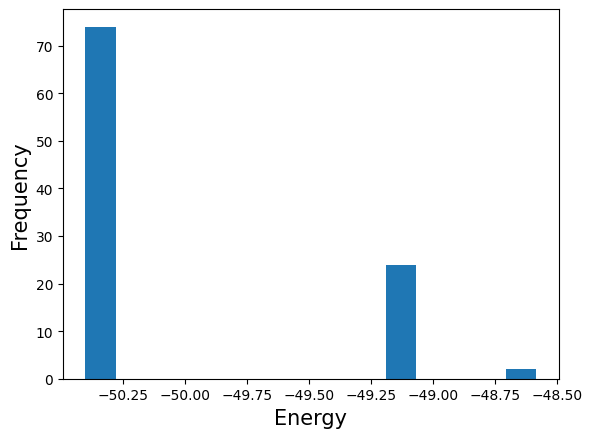

In [14]:
import matplotlib.pyplot as plt
plt.hist(response.energies, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが低いほど良い状態を算出したことになりますが、稀にエネルギーが高い状態も算出されていることが上のヒストグラムからわかります。しかし大半の計算結果はエネルギーが最低の状態を算出しています。
解いた(サンプルした)状態のうち一番低い解が最適解に近いはずなので、その解を.statesから探しましょう。
> 注意: SAは必ずしも最適解を導くものではありません。よってエネルギーが一番低い解を選んでも最適解ではないのでヒューリスティクスによる解であることを忘れないでください。

In [15]:
import numpy as np

min_samples = response.first
min_samples

Sample(sample={0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 0, 17: 0, 18: 1, 19: 0, 20: 1, 21: 1, 22: 1, 23: 1, 24: 0, 25: 1, 26: 0, 27: 1, 28: 0, 29: 1, 30: 1, 31: 1, 32: 0, 33: 1, 34: 1, 35: 1, 36: 0, 37: 1, 38: 0, 39: 1, 40: 0, 41: 0, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 0, 48: 1, 49: 0}, energy=-50.40161535006633, num_occurrences=1)

これでエネルギーが最も低い解を得ることができました。この`.first`に入っている状態が、今回得られた最良の解です。これで「最適化計算を実行した」ということになります。

ここで`num_occurrences`は計算の結果その状態が何回出力されたかを表しています。